# Modèle DL RNN et LSTM

### Modele synthèse (Uniquement BART)

In [1]:
from transformers import BartTokenizer, BartForConditionalGeneration
import torch

# 1. Chargement du modèle pré-entraîné BART (base ou large)
model_name = "facebook/bart-base"
tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name)

# 2. Texte d'entrée
texte = """
Artificial intelligence is transforming the way we work and live. From smart assistants to automated medical diagnostics, AI technologies are becoming increasingly integrated into our daily lives. However, this rapid progress also raises important questions about privacy, job displacement, and the ethical use of data.
As AI continues to evolve, it is crucial for society to address these challenges and ensure that the benefits of AI are shared equitably. Policymakers, technologists, and the public must work together to create a framework that promotes innovation while safeguarding individual rights and societal values.
The future of AI holds great promise, but it is essential to navigate the complexities it brings. By fostering collaboration and open dialogue, we can harness the power of AI to improve our world while minimizing its risks.
"""

# 3. Prétraitement : tokenisation
inputs = tokenizer(texte, return_tensors="pt", max_length=1024, truncation=True)

# 4. Encodage du texte (embedding + encoder)
with torch.no_grad():
    encoder_outputs = model.model.encoder(**inputs)
    hidden_states = encoder_outputs.last_hidden_state  # (batch_size, seq_len, hidden_dim)

# 5. Décodage
summary_ids = model.generate(
    inputs["input_ids"],
    max_length=50,
    num_beams=4,
    early_stopping=True
)

# 6. Post-traitement : génération du résumé "unembedding"
summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

print("📄 Texte original :")
print(texte)
print("\n📝 Résumé généré :")
print(summary)


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


📄 Texte original :

Artificial intelligence is transforming the way we work and live. From smart assistants to automated medical diagnostics, AI technologies are becoming increasingly integrated into our daily lives. However, this rapid progress also raises important questions about privacy, job displacement, and the ethical use of data.
As AI continues to evolve, it is crucial for society to address these challenges and ensure that the benefits of AI are shared equitably. Policymakers, technologists, and the public must work together to create a framework that promotes innovation while safeguarding individual rights and societal values.
The future of AI holds great promise, but it is essential to navigate the complexities it brings. By fostering collaboration and open dialogue, we can harness the power of AI to improve our world while minimizing its risks.


📝 Résumé généré :
Artificial intelligence is transforming the way we work and live. From smart assistants to automated medical d

Pour la classification regarder DistilBERT, RoBERTa, DeBERTa

## Modèle maison

Importation des données d'entrainement

Dataset :
- CNN/Dailymail
- Wikitext : https://huggingface.co/datasets/Salesforce/wikitext/viewer/wikitext-103-raw-v1/train?p=1&views%5B%5D=wikitext_103_raw_v1_train&row=135

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'  # affiche tous les logs
os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # forcer usage GPU 0


In [2]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

gpus = tf.config.list_physical_devices('GPU')
print("GPUs détectés :", gpus)

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


TensorFlow version: 2.19.0
GPUs détectés : []
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4622351559110675773
xla_global_id: -1
]


In [1]:
from datasets import load_dataset

dataset = load_dataset("cnn_dailymail", "3.0.0")
print(dataset["train"][0])
print(dataset.shape)


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'article': 'LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won\'t cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don\'t plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don\'t think I\'ll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK box office char

In [2]:
import numpy as np

# df_train = dataset["train"]
df_train = dataset["train"]#.shuffle(seed=42).select(range(5000)) à tester pour faciliter entrainnement du modèle
x_train = df_train["article"]
y_train = df_train["highlights"]

df_test = dataset["test"]
x_test = df_test["article"]
y_test = df_test["highlights"]

df_val = dataset["validation"]
x_val = df_val["article"]
y_val = df_val["highlights"]

mini_x_train = x_train[:1000]
mini_y_train = y_train[:1000]

mini_x_test = x_test[:100]
mini_y_test = y_test[:100]


## Modèle pour synthèse RNN et LSTM

### Modèle synthèse from scratch Seq2Seq (Encoder–Decoder)

#### Tokenisation

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer

# --- 1. Tokenisation 
num_word_token = 500000
tokenizer = Tokenizer(num_words=num_word_token, oov_token="<unk>")

complet_text = x_train + y_train

#Ajout de token spéciaux pour le modèle (afin qu'il reconnaisse les séquences de début et de fin et pas a la fin de chaque phrase car sinon on casse le rythme du modèle seq to seq)
texts_for_fit = ["<sos> " + s + " <eos>" for s in complet_text]
texts_for_fit_x = ["<sos> " + s + " <eos>" for s in x_train]
texts_for_fit_y = ["<sos> " + s + " <eos>" for s in y_train]

tokenizer.fit_on_texts(texts_for_fit)

# --- 2. Conversion en séquences
x_train_seq = tokenizer.texts_to_sequences(texts_for_fit_x)

print(x_train_seq[0])
# Vérification que les tokens spéciaux sont bien indexés
print("Index des tokens spéciaux :")
print("sos index:", tokenizer.word_index.get('sos'))
print("eos index:", tokenizer.word_index.get('eos'))
print("unk index:", tokenizer.word_index.get('unk')) #=> Pour les mots inconnus donc retourne None
print("Taille vocabulaire:", len(tokenizer.word_index))

#Le tokenizer enlève les caractère spéciaux, comme les apostrophes, les tirets, etc. => Ce qui explique pourquoi on ne voit plus les <>


[42, 216, 305, 6588, 1494, 6133, 384, 1663, 13473, 6916, 1020, 3, 4, 287, 5379, 217, 2102, 134, 217, 3842, 19, 13, 3094, 392, 10, 311, 26, 13, 2783, 2, 261, 1349, 2502, 4, 4181, 10, 61, 1663, 13473, 19, 1494, 6133, 7, 1494, 6133, 5, 2, 603, 6, 2, 4892, 3, 2, 6514, 6, 10081, 38521, 124, 2, 105, 2, 234, 1569, 93, 13, 23, 75, 656, 3, 84545, 16, 1259, 211, 10, 1420, 1096, 1572, 5, 2159, 1761, 31, 226, 725, 3, 24, 44, 6, 139, 59, 33, 19, 697, 19, 30, 826, 392, 2846, 1107, 807, 4, 1529, 1144, 231, 1435, 53, 307, 798, 13, 73, 29, 1008, 15644, 343, 35, 203, 31, 226, 165, 3178, 24, 1308, 10797, 2, 396, 31, 89, 2570, 27, 396, 11, 664, 52, 185, 1751, 1888, 5, 19496, 5, 13735, 18, 392, 13473, 41, 24, 328, 3, 10928, 7, 4, 6026, 1107, 4, 1572, 7, 4, 3075, 53, 155, 2, 3513, 591, 13059, 177, 2387, 686, 232, 1535, 1563, 16, 252, 44, 1306, 10, 2, 314, 1438, 325, 7605, 1016, 6, 113, 4924, 630, 16, 5522, 1706, 27, 161, 13067, 16, 1936, 5, 10150, 32, 75, 980, 10, 16, 656, 3178, 2575, 22, 88, 1925, 6, 308, 

2224


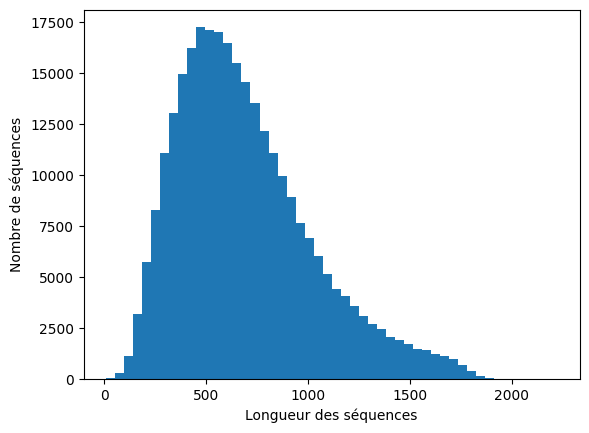

Nombre de texte sup à 250 tokens : 13704 ce qui représente 4.77% du dataset
Nous allons partir sur un troncage à 250 token pour facilité l'entrainnement du modèle


In [4]:
# Obtenir le nombre max de token d'une sequence sur tout le dataset
max_len = max(len(seq) for seq in x_train_seq)
print(max_len)

import matplotlib.pyplot as plt

seq_lengths = [len(seq) for seq in x_train_seq]
plt.hist(seq_lengths, bins=50)
plt.xlabel('Longueur des séquences')
plt.ylabel('Nombre de séquences')
plt.show()

len_token_sentence = 250

seq_lengths = np.array(seq_lengths)
nb_inf = np.sum(seq_lengths < len_token_sentence)
part_nb_inf = round((nb_inf/len(seq_lengths))*100,2)
print(f'Nombre de texte sup à 250 tokens : {nb_inf} ce qui représente {part_nb_inf}% du dataset')
print("Nous allons partir sur un troncage à 250 token pour facilité l'entrainnement du modèle")

### Filtrage du dataset pour éviter le troncage

In [ ]:
x_train_seq2 = []
x_train2 =[]
for i in x_train_seq:
    if len(i) <250 :
         x_train_seq2.append(i)

print(len(x_train_seq2))
Nb_token = [len(seq) for seq in x_train_seq2]
print(max(Nb_token))
print(x_train_seq2[:10])

13704
249
[[42, 627, 129, 1764, 156, 7723, 9771, 41, 1864, 19, 2201, 156, 4981, 395, 96, 156, 1664, 12, 108176, 9, 4, 3414, 37980, 295, 150, 400, 1910, 1445, 15, 339, 1664, 12, 1938, 3, 22, 2, 515, 2996, 474, 3, 137, 52, 194, 134, 194, 282, 18, 2, 1383, 6440, 18, 1374, 330, 3999, 1445, 15, 9143, 65, 37980, 8, 7, 540, 2167, 5, 75, 18071, 39, 109, 1445, 15, 2, 3329, 1230, 32, 4218, 4, 4944, 2996, 7, 52, 182, 74, 2, 2996, 41, 24, 11061, 20, 511, 1244, 79420, 5, 2553, 20, 4, 64342, 162, 21, 2, 237, 5119, 515, 618, 7, 24681, 3999, 1445, 15, 4, 37980, 12, 2, 115, 3856, 823, 9, 14001, 619, 41746, 619, 5, 60936, 495, 28211, 6, 2616, 11, 66, 370, 14174, 136, 3, 2, 12987, 3102, 495, 60936, 120, 24, 1340, 104, 2, 2996, 1445, 15, 11, 8, 2, 215, 45, 1664, 32, 61472, 81, 1505, 156, 1445, 454, 12, 5278, 5250, 9, 619, 11, 452, 7, 16, 14001, 5, 1631, 3, 16, 4857, 1445, 73, 1402, 13, 32, 4, 19339, 2178, 1938, 193, 339, 524, 1445, 886, 52, 9143, 2996, 5, 16, 207, 14001, 619, 2346, 2, 156, 805, 3, 3009, 2

### Embedding

In [7]:
from gensim.models import Word2Vec

sentences = [s.split() for s in texts_for_fit_x]
word2vec = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

embedding_dim = 100  
word_index = tokenizer.word_index
vocab_size = min(num_word_token, len(word_index)) + 1

# Matrice initialisée à zéro
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Remplir la matrice avec les vecteurs Word2Vec
for word, i in word_index.items():
    if i >= vocab_size:
        continue
    if word in word2vec.wv:
        embedding_matrix[i] = word2vec.wv[word]
    else:
        # Sinon, laisse un vecteur nul (ou tu peux mettre du bruit aléatoire)
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim,))

In [8]:
#Exemple d'un token avec ça correspondance en vecteur
print(tokenizer.word_index.get('to'))
print(embedding_matrix[3])
print(embedding_matrix.shape)

3
[-4.92345572e+00  7.00824082e-01  6.89447641e+00 -1.69778454e+00
 -1.98331928e+00  1.00524592e+00 -2.15554476e+00 -2.09611154e+00
  2.70765205e-03 -1.44053653e-01  2.30726004e+00  1.75514603e+00
 -1.90051985e+00  5.27853870e+00  1.48908424e+00 -6.29056597e+00
 -5.41666985e+00 -2.59624076e+00 -3.68269491e+00  9.63919982e-02
 -4.05941105e+00 -3.91365051e+00  4.85412312e+00 -1.62773871e+00
  1.07523906e+00  7.09555209e-01  1.19434893e+00  3.07036161e+00
  2.68337607e+00  1.19562280e+00  2.00057435e+00  3.50957721e-01
 -3.33754897e+00  4.75333273e-01 -4.35329229e-02  3.03540683e+00
 -1.35771430e+00 -4.77833420e-01  4.51404953e+00  5.12701225e+00
 -4.12617445e+00 -2.84520268e+00  3.34777784e+00 -2.57369187e-02
  3.91687441e+00  3.87300682e+00  1.50426126e+00 -5.03843546e+00
 -3.81812429e+00 -2.44377255e+00  2.14896107e+00 -5.36380434e+00
  9.21726763e-01 -1.27962029e+00 -3.37533474e+00  9.32780683e-01
  6.46621406e-01  2.25621057e+00  2.78801955e-02  1.58035040e+00
 -3.27982950e+00  3.096

### Padding
Pas directement utile pour l'entrainnement (car on va refaire un padding pour chaque élément du modèle) mais pour les contrôles

In [9]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

x_train_padded = pad_sequences(x_train_seq2, maxlen =249, padding = 'post', value = 0 )
print(x_train_padded[0])
print(len(x_train_padded[0]))
print(len(x_train_padded))
print(x_train_padded.dtype)

[    42    627    129   1764    156   7723   9771     41   1864     19
   2201    156   4981    395     96    156   1664     12 108176      9
      4   3414  37980    295    150    400   1910   1445     15    339
   1664     12   1938      3     22      2    515   2996    474      3
    137     52    194    134    194    282     18      2   1383   6440
     18   1374    330   3999   1445     15   9143     65  37980      8
      7    540   2167      5     75  18071     39    109   1445     15
      2   3329   1230     32   4218      4   4944   2996      7     52
    182     74      2   2996     41     24  11061     20    511   1244
  79420      5   2553     20      4  64342    162     21      2    237
   5119    515    618      7  24681   3999   1445     15      4  37980
     12      2    115   3856    823      9  14001    619  41746    619
      5  60936    495  28211      6   2616     11     66    370  14174
    136      3      2  12987   3102    495  60936    120     24   1340
    10

In [15]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# 1. Séquences source (encodeur) — sans <sos> ni <eos>
x_train_seq_without_spetk = [
    [elem for elem in seq if elem not in (42, 43)]
    for seq in x_train_seq2
]
# encoder_input_seq = tokenizer.texts_to_sequences(x_train_seq_without_spetk)
encoder_input_seq = pad_sequences(x_train_seq_without_spetk,maxlen =249, padding = 'post', value = 0 )

# 2. Décodeur - entrée (avec <sos>, sans <eos>)
decoder_input_seq = tokenizer.texts_to_sequences(["<sos> " + s for s in y_train])
decoder_input_seq = pad_sequences(decoder_input_seq,maxlen =249, padding = 'post', value = 0 )

# 3. Décodeur - cible (sans <sos>, avec <eos>)
decoder_target_seq = tokenizer.texts_to_sequences([s + " <eos>" for s in y_train])
decoder_target_seq = pad_sequences(decoder_target_seq,maxlen =249, padding = 'post', value = 0 )

# 4. Adapter au format attendu (shape = (batch, seq_len, 1))
decoder_target_seq = np.expand_dims(decoder_target_seq, -1)


### Création du modèle

In [16]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Attention, Concatenate

# --- Paramètres
latent_dim = 249
vocab_size = embedding_matrix.shape[0]
embedding_dim = embedding_matrix.shape[1]
max_seq_len = x_train_padded.shape[1]

# --- Encoder
encoder_inputs = Input(shape=(max_seq_len,))
encoder_embedding_layer = Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    input_length=max_seq_len,
    trainable=True #Fine-tune l'embedding afin de l'adapter au mieux au data d'entrainnement
)

encoder_embedding = encoder_embedding_layer(encoder_inputs)#Pour ne pas perdre la référence de la couche
encoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]


# --- Decoder
decoder_inputs = Input(shape=(None,))  # Attention : None pour pouvoir générer pas à pas
decoder_embedding_layer = Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    trainable=True #Fine-tune l'embedding afin de l'adapter au mieux au data d'entrainnement
)
decoder_embedding = decoder_embedding_layer(decoder_inputs) #Pour ne pas perdre la référence de la couche
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)

# -- Attention (Luong-like avec multiplicative score)
attention_layer = Attention()
attention_outputs = attention_layer([decoder_outputs, encoder_outputs])  # shape: (batch, tgt_len, latent_dim)

# -- Concatener contexte + sortie décodeur
decoder_combined_context = Concatenate(axis=-1)([decoder_outputs, attention_outputs])

# --- Dense de sortie
decoder_dense = Dense(vocab_size, activation='softmax')  # projection sur le vocab
decoder_outputs = decoder_dense(decoder_combined_context)

# --- Modèle final (entraînement)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
# sparse_categorical_crossentropy (et pas categorical_crossentropy) car cible sont des entiers et non des vecteurs one-hot
# On ajoute pas de metrics comme accuracy car elle serait calculé token par token ce qui est trompeur (pas bon KPI) car on veux évaluer le sens global de la phrase pas juste correspondance des tokens


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


#### Entrainnement du modèle

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint



early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,              # Nombre d'époques sans amélioration avant arrêt
    restore_best_weights=True,  # Revenir aux meilleurs poids
    verbose=1
)

checkpoint = ModelCheckpoint(
    filepath='best_seq2seq_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

history = model.fit(
    [encoder_input_seq, decoder_input_seq],
    decoder_target_seq,
    batch_size=8,
    epochs=50,
    validation_split=0.1,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/50
  84/1542 ━━━━━━━━━━━━━━━━━━━━ 5:53:28 15s/step - loss: 6.6857

#### Importation modèle

In [ ]:
# from tensorflow.keras.models import load_model

# # Charge le modèle entraîné
model = save_model('best_seq2seq_model.h6', compile=False)
model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 500)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_9       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_8         │ (None, 500, 100)  │  9,197,200 │ input_layer_8[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_9         │ (None, None, 100) │  9,197,200 │ input_layer_9[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ [(None, 500,      │    365,568 │ embedding_8[0][0] │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_9 (LSTM)       │ [(None, None,     │    365,568 │ embedding_9[0][0… │
│                     │ 256), (None,      │            │ lstm_8[0][1],     │
│                     │ 256), (None,      │            │ lstm_8[0][2]      │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_4         │ (None, None, 256) │          0 │ lstm_9[0][0],     │
│ (Attention)         │                   │            │ lstm_8[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, None, 512) │          0 │ lstm_9[0][0],     │
│ (Concatenate)       │                   │            │ attention_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, None,      │ 47,181,636 │ concatenate_4[0]… │
│                     │ 91972)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 66,307,172 (252.94 MB)

 Trainable params: 66,307,172 (252.94 MB)

 Non-trainable params: 0 (0.00 B)

### Création des modèles d'inférences (encoder et décoder)
(pour générer le texte par utilisation des poid du modèle précédement entrainné)

#### Modèle encodeur d’inférence

In [ ]:
from tensorflow.keras.models import Model

# On suppose que le modèle complet a bien été chargé
# model = load_model(...)

# Récupération des bonnes entrées et couches
encoder_inputs = model.input[0]

# Tu récupères directement les sorties de la couche LSTM
encoder_outputs, state_h_enc, state_c_enc = model.get_layer('lstm_8').output
encoder_model = Model(encoder_inputs, [encoder_outputs, state_h_enc, state_c_enc])


#### Modèle décodeur d’inférence avec attention

In [ ]:
from tensorflow.keras.layers import Input, Concatenate

latent_dim = 256  # ou extrais-le du modèle
decoder_inputs_single = Input(shape=(1,), name="decoder_input_infer")
decoder_state_input_h = Input(shape=(latent_dim,), name="input_h")
decoder_state_input_c = Input(shape=(latent_dim,), name="input_c")
decoder_hidden_state_input = Input(shape=(None, latent_dim), name="encoder_outputs")

# Récupération des bonnes couches
decoder_embedding_layer = model.get_layer('embedding_9')  # vérifie le nom exact
decoder_lstm_layer = model.get_layer('lstm_9')
attention_layer = model.get_layer('attention_4')
dense_layer = model.get_layer('dense_4')

# Embedding
decoder_embedding = decoder_embedding_layer(decoder_inputs_single)

# LSTM
decoder_outputs, state_h, state_c = decoder_lstm_layer(
    decoder_embedding, initial_state=[decoder_state_input_h, decoder_state_input_c]
)

# Attention
attention_out = attention_layer([decoder_outputs, decoder_hidden_state_input])
decoder_combined_context = Concatenate(axis=-1)([decoder_outputs, attention_out])

# Projection finale
decoder_outputs = dense_layer(decoder_combined_context)

# Modèle d'inférence du décodeur
decoder_model = Model(
    [decoder_inputs_single, decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs, state_h, state_c]
)


In [ ]:
# ## Modèle d'inférence pour encoder = utiliser le même que pour entrainnement
# # Encoder d'inférence (on donne une séquence source et on récupère les états)
# encoder_model = Model(encoder_inputs, encoder_states)

# # Entrées du décodeur
# decoder_state_input_h = Input(shape=(latent_dim,))
# decoder_state_input_c = Input(shape=(latent_dim,))
# decoder_hidden_state_input = Input(shape=(max_seq_len, latent_dim))  # encoder_outputs

# decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# decoder_inputs_single = Input(shape=(1,))
# decoder_embedding_inf = decoder_embedding_layer(decoder_inputs_single)

# decoder_lstm_outputs, state_h_inf, state_c_inf = decoder_lstm(
#     decoder_embedding_inf, initial_state=decoder_states_inputs
# )

# # Appliquer l'attention
# attention_inf = attention_layer([decoder_lstm_outputs, decoder_hidden_state_input])
# decoder_combined_context = Concatenate(axis=-1)([decoder_lstm_outputs, attention_inf])

# # Projection finale
# decoder_outputs = decoder_dense(decoder_combined_context)

# # Modèle d'inférence du décodeur complet
# decoder_model = Model(
#     [decoder_inputs_single, decoder_hidden_state_input] + decoder_states_inputs,
#     [decoder_outputs, state_h_inf, state_c_inf]
# )



### Fonction de génération de texte (green decoding)

In [ ]:
import numpy as np

def decode_sequence(input_seq, tokenizer, reverse_index, max_decoder_seq_len, start_token='sos', end_token='eos'):
    # Encode l'entrée
    encoder_outputs, state_h, state_c = encoder_model.predict(input_seq)

    target_seq = np.array([[tokenizer.word_index[start_token]]])
    stop_condition = False
    decoded_sentence = []

    while not stop_condition and len(decoded_sentence) < max_decoder_seq_len:
        output_tokens, h, c = decoder_model.predict(
            [target_seq, encoder_outputs, state_h, state_c]
        )

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = reverse_index.get(sampled_token_index, '')

        if sampled_word == end_token or sampled_word == '':
            stop_condition = True
        else:
            decoded_sentence.append(sampled_word)

        target_seq = np.array([[sampled_token_index]])
        state_h, state_c = h, c

    return ' '.join(decoded_sentence)


In [ ]:
# def decode_sequence(input_seq, tokenizer, max_target_len=50):
#     # Encode la séquence d'entrée
#     states_value = encoder_model.predict(input_seq)

#     # Token de départ (index de <sos>)
#     sos_index = tokenizer.word_index['sos']
#     eos_index = tokenizer.word_index['eos']

#     target_seq = np.array([[sos_index]])

#     decoded_sentence = []
    
#     for _ in range(max_target_len):
#         output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

#         # Choisir le token avec la plus grande probabilité
#         sampled_token_index = np.argmax(output_tokens[0, -1, :])
#         sampled_word = tokenizer.index_word.get(sampled_token_index, "<unk>")

#         if sampled_word == 'eos':
#             break

#         decoded_sentence.append(sampled_word)

#         # Le token généré devient la prochaine entrée du décodeur
#         target_seq = np.array([[sampled_token_index]])
#         states_value = [h, c]

#     return ' '.join(decoded_sentence)


### Test d'utilisation

Faire attention a ce putain de troncage qui supprimer les eos avant l'entrainnement

In [ ]:
# Suppose que tu veux générer à partir de la première séquence x_test
input_seq = x_train_padded[0:1]

token_ids = input_seq[0]  # shape (seq_len,)
# Étape 2 : Reconvertir vers les mots
reverse_index = tokenizer.index_word  # {index: word}
decoded_input = ' '.join([reverse_index.get(idx, '') for idx in token_ids if idx != 0])
print(decoded_input)

print(input_seq)  # Doit être shape (1, seq_len)
generated_summary = decode_sequence(input_seq, tokenizer,tokenizer.index_word,100)

print("Résumé généré :")
print(generated_summary)

an interview hopefully none of you will be reading about it radcliffe's earnings from the first five potter films have been held in a trust fund which he has not been able to touch despite his growing fame and riches the actor says he is keeping his feet firmly on the ground people are always looking to say 'kid star goes off the rails ' he told reporters last month but i try very hard not to go that way because it would be too easy for them his latest outing as the boy wizard in harry potter and the order of the phoenix is breaking records on both sides of the atlantic and he will reprise the role in the last two films watch i reporter give her review of potter's latest » there is life beyond potter however the londoner has filmed a tv movie called my boy jack about author rudyard kipling and his son due for release later this year he will also appear in december boys an australian film about four boys who escape an orphanage earlier this year he made his stage debut playing a torture

ValueError: Input 0 of layer "functional_1" is incompatible with the layer: expected shape=(None, 500), found shape=(1, 249)

## Tentative foirée

Explication choix de la structure :
- Tokenisation 

In [ ]:
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Embedding, LSTM, Dense

# # --- 1. Tokenisation 
# num_word_token = 15000
# tokenizer = Tokenizer(num_words=num_word_token, oov_token="<unk>")
# tokenizer.fit_on_texts(mini_x_train + ["<sos> " + s + " <eos>" for s in mini_y_train])

# encoder_input = tokenizer.texts_to_sequences(mini_x_train)
# decoder_input = tokenizer.texts_to_sequences(["<sos> " + s for s in mini_y_train])
# decoder_target = tokenizer.texts_to_sequences([s + " <eos>" for s in mini_y_train])

# encoder_input_test = tokenizer.texts_to_sequences(mini_x_test)
# decoder_input_test = tokenizer.texts_to_sequences(["<sos> " + s for s in mini_y_test])
# decoder_target_test = tokenizer.texts_to_sequences([s + " <eos>" for s in mini_y_test])


# print(tokenizer.word_index.get('<sos>'))
# print(tokenizer.word_index.get('<eos>'))
# print(tokenizer.word_index.get('<unk>'))
# print(tokenizer.word_index.get('<pad>'))

# # --- 2. Padding 
# max_len_x = max(len(s) for s in encoder_input)
# max_len_y = max(len(s) for s in decoder_input)

# encoder_input = pad_sequences(encoder_input, maxlen=max_len_x, padding='post')
# decoder_input = pad_sequences(decoder_input, maxlen=max_len_y, padding='post')
# decoder_target = pad_sequences(decoder_target, maxlen=max_len_y, padding='post')

# encoder_input_test = pad_sequences(encoder_input_test, maxlen=max_len_x, padding='post')
# decoder_input_test = pad_sequences(decoder_input_test, maxlen=max_len_y, padding='post')
# decoder_target_test = pad_sequences(decoder_target_test, maxlen=max_len_y, padding='post')

# # --- 3. Hyperparamètres ---
# dim_embedding = 150
# lstm_units = 256

# # --- 4. Modèle d'entraînement (encodeur + décodeur) ---> teacher forcing

# # Encodeur
# enc_in = Input(shape=(max_len_x,), name='encoder_input')
# enc_emb = Embedding(num_word_token, dim_embedding, name='encoder_embedding')(enc_in)
# enc_out, state_h, state_c = LSTM(lstm_units, return_state=True, name='encoder_lstm')(enc_emb)

# # Décodeur (entrée)
# dec_in = Input(shape=(max_len_y,), name='decoder_input')
# dec_emb = Embedding(num_word_token, dim_embedding, name='decoder_embedding')(dec_in)

# # Décodeur LSTM avec initialisation des états par l'encodeur
# dec_lstm, _, _ = LSTM(
#     lstm_units, return_sequences=True, return_state=True, name='decoder_lstm')(
#         dec_emb, initial_state=[state_h, state_c])

# # Couche dense pour prédiction sur vocabulaire
# dec_out = Dense(num_word_token, activation='softmax', name='decoder_dense')(dec_lstm)

# # Modèle complet pour entraînement avec teacher forcing
# model = Model([enc_in, dec_in], dec_out)
# model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=['accuracy'])

# # --- 5. Modèle encodeur pour inférence ---> pour générer les états cachés

# # Ce modèle prend la séquence source et retourne les états cachés
# encoder_model = Model(enc_in, [state_h, state_c])

# # --- 6. Modèle décodeur pour inférence ---

# # Entrées pour un seul token + états cachés initiaux
# decoder_state_input_h = Input(shape=(lstm_units,), name='decoder_state_input_h')
# decoder_state_input_c = Input(shape=(lstm_units,), name='decoder_state_input_c')
# decoder_single_input = Input(shape=(1,), name='decoder_single_input')  # un mot à la fois

# # Embedding du token unique
# dec_emb2 = Embedding(num_word_token, dim_embedding, name='decoder_embedding')(decoder_single_input)

# # LSTM pour un pas de temps, initialisé avec les états précédents
# dec_lstm2, state_h2, state_c2 = LSTM(
#     lstm_units, return_sequences=True, return_state=True, name='decoder_lstm'
# )(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# # Couche dense pour prédire le prochain mot
# dec_out2 = Dense(num_word_token, activation='softmax', name='decoder_dense')(dec_lstm2)

# # Modèle décodeur inférence
# decoder_model = Model(
#     [decoder_single_input, decoder_state_input_h, decoder_state_input_c],
#     [dec_out2, state_h2, state_c2]
# )
# # --- 7. Entraînement du modèle ---
# model.fit(
#     [encoder_input, decoder_input],
#     np.expand_dims(decoder_target, -1),
#     batch_size=64,
#     epochs=5,
#     validation_split=0.1
# )

# # --- 8. Fonction d'inférence (génération autonome) ---
# def decode_sequence(input_seq, max_len=max_len_y):
#     states_value = encoder_model.predict(input_seq)
#     sos_token_index = tokenizer.word_index.get('<sos>')
#     if sos_token_index is None:
#         raise ValueError("Le tokenizer doit contenir le token <sos>")
#     target_seq = np.array([[sos_token_index]])

#     stop_condition = False
#     decoded_sentence = []

#     state_h, state_c = states_value

#     for _ in range(max_len):
#         output_tokens, h, c = decoder_model.predict([target_seq, state_h, state_c])
#         sampled_token_index = np.argmax(output_tokens[0, -1, :])
#         sampled_word = tokenizer.index_word.get(sampled_token_index, '<unk>')

#         if sampled_word == '<eos>' or sampled_word == '<pad>':
#             break

#         decoded_sentence.append(sampled_word)
#         target_seq = np.array([[sampled_token_index]])
#         state_h, state_c = h, c

#     return ' '.join(decoded_sentence)

# # --- 8. Test de génération sur quelques exemples ---
# for i in range(5):
#     input_seq = encoder_input_test[i:i+1]
#     print(f"--- Exemple {i+1} ---")
#     print("Texte source :", mini_x_test[i])
#     print("Résumé attendu :", mini_y_test[i])
#     print("Résumé généré :", decode_sequence(input_seq))
#     print()

None
None
1
None
Epoch 1/5


KeyboardInterrupt: 

In [ ]:
# model.fit(
#     [encoder_input, decoder_input],
#     np.expand_dims(decoder_target, -1),
#     batch_size=64,
#     epochs=5,
#     validation_split=0.1
# )

Epoch 1/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 198s 12s/step - accuracy: 0.2957 - loss: 9.1615 - val_accuracy: 0.3739 - val_loss: 6.2785
Epoch 2/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 177s 12s/step - accuracy: 0.3754 - loss: 5.7393 - val_accuracy: 0.3739 - val_loss: 5.4796
Epoch 3/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 173s 12s/step - accuracy: 0.3774 - loss: 5.1840 - val_accuracy: 0.3739 - val_loss: 5.2785
Epoch 4/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 241s 16s/step - accuracy: 0.3751 - loss: 4.9861 - val_accuracy: 0.3739 - val_loss: 5.1780
Epoch 5/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 239s 16s/step - accuracy: 0.3756 - loss: 4.8529 - val_accuracy: 0.3739 - val_loss: 5.0360


In [ ]:
# #5. Prédiction et évaluation
# loss, metrics = model.evaluate(
#     [encoder_input_test, decoder_input_test],
#     np.expand_dims(decoder_target_test, -1)
# )
# if metrics:
#     print("Metrics:", metrics)
#     print("Loss:", loss)

# model.save(r"Model/DL/mon_modele.h5")



4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.4846 - loss: 3.9031


Metrics: 0.494242399930954
Loss: 3.838369846343994


In [ ]:
# texte = """
# Artificial intelligence is transforming the way we work and live. From smart assistants to automated medical diagnostics, AI technologies are becoming increasingly integrated into our daily lives. However, this rapid progress also raises important questions about privacy, job displacement, and the ethical use of data.
# As AI continues to evolve, it is crucial for society to address these challenges and ensure that the benefits of AI are shared equitably. Policymakers, technologists, and the public must work together to create a framework that promotes innovation while safeguarding individual rights and societal values.
# The future of AI holds great promise, but it is essential to navigate the complexities it brings. By fostering collaboration and open dialogue, we can harness the power of AI to improve our world while minimizing its risks.
# """


# def encode_text(texte):
#     inputs = tokenizer.texts_to_sequences(texte)
#     inputs = pad_sequences(inputs, maxlen=max_len_x, padding='post')
    
#     return inputs

# model.predict(encode_text(texte))


    
# # model.predict(texte)

Texte encodé : [[   0    0    0 ...    0    0    0]
 [   5    0    0 ...    0    0    0]
 [1356    0    0 ...    0    0    0]
 ...
 [  50    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]]
